## N-Qubit Boltzmann Machine

We use a n-qubit system, where the goal is to learn the parameters of the Ising Hamiltonian:

$H = \sum_{i} \sum_{j}\sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_i^k \otimes \sigma_j^{k'} + \sum_{i}\sum_{k} h^k_i \sigma_{i}^k$

where $w_{ij}^{kk'}$ is the coupling strength, $h_i$ are the local fields, and $\sigma_i^k$ are the Pauli operators. For the Pauli matrices, indexes $k=1,2,3$ correspond to $x,y,z$, index $k=0$ to the identity. The explicit Hamiltonian is written as:

$H = \sum_{k} \sum_{k'} w_{ij}^{kk'} \sigma_0^k \otimes \sigma_1^{k'} + h^k_0 \sigma_0^k \otimes \sigma_1^0 + h^{k'}_1 \sigma_0^0 \otimes \sigma_1^{k'}$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from numba import njit
from itertools import product
from scipy.linalg import kron

### Defining the interaction matrices and their weights

In [2]:
# define the Pauli matrices globally
PAULI_I = np.array([[1, 0], [0, 1]], dtype=np.complex128)
PAULI_X = np.array([[0, 1], [1, 0]], dtype=np.complex128)
PAULI_Y = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
PAULI_Z = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# create an array of Pauli matrices and their labels
PAULI_MATRICES = np.array([PAULI_I, PAULI_X, PAULI_Y, PAULI_Z], dtype=np.complex128)
PAULI_LABELS = ['I', 'X', 'Y', 'Z']

In [3]:
def tensor_product(matrices):
    """Compute the tensor product of a list of matrices."""
    result = matrices[0]
    # iterate over each matrix in the list starting from the second one
    for matrix in matrices[1:]:
        result = kron(result, matrix)
    return result
 
def generate_interaction_matrices(num_qubits):
    """Constructs the tensor product of Pauli matrices for each qubit pair."""
    num_combinations = 4 ** num_qubits # total number of combinations of Pauli matrices for num_qubits
    interaction_matrices = np.empty((num_combinations, 2 ** num_qubits, 2 ** num_qubits), dtype=np.complex128) 
    interaction_labels = np.empty((num_combinations, num_qubits), dtype=object)

    # initialize an empty dictionary to store the weights associated with each interaction matrix
    interaction_weights = {}

    # enumerate over all possible combinations of Pauli matrices for num_qubits
    for idx, matrix_indices in enumerate(product(range(4), repeat=num_qubits)):
        # select the corresponding Pauli matrices for the current combination
        matrices = PAULI_MATRICES[list(matrix_indices)]
        # compute the tensor product of the selected matrices
        interaction_matrix = tensor_product(matrices)

        # store the computed tensor product matrix and its corresponding labe
        interaction_matrices[idx] = interaction_matrix
        label_tuple = tuple(PAULI_LABELS[i] for i in matrix_indices)
        interaction_labels[idx] = label_tuple

        # initialize the weight associated with this interaction matrix
        # by default, it is set to None. You can change it later.
        interaction_weights[label_tuple] = None

    return interaction_matrices, interaction_labels, interaction_weights

**"interaction_matrices" is an array that holds the tensor product of Pauli matrices for each possible combination of qubits. It is ordered lexicographically. For a 3-qubit system the first entries look like this:**

In [4]:
def print_matrix(matrix):
    for row in matrix:
        print('[', end='')
        for elem in row:
            real = elem.real
            imag = elem.imag
            if abs(real) < 1e-10 and abs(imag) < 1e-10:
                print("0", end=' ')
            elif abs(real) < 1e-10:
                print(f"{imag:.0f}j", end=' ')
            elif abs(imag) < 1e-10:
                print(f"{real:.0f}", end=' ')
            else:
                print(f"{real:.0f}+{imag:.2f}j", end=' ')
        print(']')
    print()
    

interactions, interaction_labels, interaction_weights = generate_interaction_matrices(3)

for i, label in enumerate(interaction_labels[:10]):
    print(label)
    # print_matrix(interactions[i])  #uncomment to see the associated matrix with each label

['I' 'I' 'I']
['I' 'I' 'X']
['I' 'I' 'Y']
['I' 'I' 'Z']
['I' 'X' 'I']
['I' 'X' 'X']
['I' 'X' 'Y']
['I' 'X' 'Z']
['I' 'Y' 'I']
['I' 'Y' 'X']


**This lexiographic ordering is not very intuitive to index with weights. Because the amount of interaction matrices scales with $4^N$, it is non-trivial to index the weights, despite what kind of ordering we use. We can circumvent this problem by using a dictionary structure for the weights. We can then set the weights using the the interaction labels as follows:**

In [5]:
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(3)

interaction_weights[('I', 'I', 'I')] = .1
interaction_weights[('I', 'I', 'X')] = .2
interaction_weights[('I', 'I', 'Y')] = .3
interaction_weights[('I', 'I', 'Z')] = .4
interaction_weights[('I', 'X', 'I')] = .5
interaction_weights[('I', 'X', 'X')] = .6
interaction_weights[('I', 'X', 'Y')] = .7
#interactions that are not defined, are automatically set to 0

**Let's test if this structure works as intended. We print the weight and interaction matrix associated with $\sigma_{23}^{xy}$ and $\sigma_{123}^{zxy}$:**

In [6]:
def test_interaction(label_tuple, interaction_matrices, interaction_labels, interaction_weights):
    """
    Given an interaction label, prints the associated interaction matrix and the associated weight.
    """
    # find the index of the label tuple in interaction_labels
    idx = np.where(np.all(interaction_labels == label_tuple, axis=1))[0][0]

    # fetch the corresponding interaction matrix
    interaction_matrix = interaction_matrices[idx]

    # fetch the corresponding weight
    weight = interaction_weights.get(label_tuple, None)

    print("Interaction Matrix for {}: \n".format(label_tuple))
    print_matrix(interaction_matrix)
    print("Associated weight: ", weight)

test_interaction(('I', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)
test_interaction(('Z', 'X', 'Y'), interaction_matrices, interaction_labels, interaction_weights)

Interaction Matrix for ('I', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 -1j ]
[0 0 0 0 0 0 1j 0 ]
[0 0 0 0 0 -1j 0 0 ]
[0 0 0 0 1j 0 0 0 ]

Associated weight:  0.7
Interaction Matrix for ('Z', 'X', 'Y'): 

[0 0 0 -1j 0 0 0 0 ]
[0 0 1j 0 0 0 0 0 ]
[0 -1j 0 0 0 0 0 0 ]
[1j 0 0 0 0 0 0 0 ]
[0 0 0 0 0 0 0 1j ]
[0 0 0 0 0 0 -1j 0 ]
[0 0 0 0 0 1j 0 0 ]
[0 0 0 0 -1j 0 0 0 ]

Associated weight:  None


**If we want our code to be compatible with numba NJIT compilation, we can't use dictionary formatting for our weights. However, we want to maintain the dictionary structure because it makes it significantly easier to associate a weight with each interaction matrix than using array indexing (which is varying for different amount of qubits). We thus need a way to convert a weights dictionary to 1D numpy array and vice versa:**

In [7]:
def weights_dict_to_array(interaction_labels, interaction_weights):
    """
    Converts the interaction_weights dictionary to a numpy array based on the order of interaction_labels.
    """
    weights_array = np.array([interaction_weights[tuple(label)] if interaction_weights[tuple(label)] is not None else 0 for label in interaction_labels])
    return weights_array

def weights_array_to_dict(interaction_labels, weights_array):
    """
    Converts a numpy array to an interaction_weights dictionary based on the order of interaction_labels.
    """
    interaction_weights = {tuple(label): weights_array[i] for i, label in enumerate(interaction_labels)}
    return interaction_weights

def generate_random_parameter_matrix(random_seed, num_qubits, interaction_labels, order = 2):
    """
    Generates a random parameter array for the random seed value random_seed.
    Interactions containing more than 2-body interactions are set to zero.
    """
    np.random.seed(random_seed)  # set the random seed value
    num_params = 4**num_qubits   # calculate the number of parameters for the weight matrix
    w_array = np.random.rand(num_params)  # generate a random parameter array of size num_params

    # iterate over the interaction labels
    for i, label_tuple in enumerate(interaction_labels):
        # count the number of 'I' in the current label tuple
        num_I = np.count_nonzero(label_tuple == 'I')
        # if there are more than 2 'I', set the corresponding weight to 0
        if num_I < num_qubits - order:
            w_array[i] = 0

    w_array[0] = 0 # -log(Z) = 0
    return w_array


**Let's test if these functions work as intended. We generate a random weight matrix with only up to 2-body interactions allowed and translate it to a dictionary structure and back**

In [8]:
# generate random weights array
random_seed = 666
num_qubits = 2
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)
w_random = generate_random_parameter_matrix(random_seed, num_qubits, interaction_labels)
print("Initial weights array: \n", w_random)

# numpy array to weights dictionary
interaction_weights = weights_array_to_dict(interaction_labels, w_random)
print("Weights dictionary:")
for interaction_label, interaction_weight in interaction_weights.items():
    print(interaction_label, format(interaction_weight, ".2f"))

# weights dictionary to numpy array
weights_array = weights_dict_to_array(interaction_labels, interaction_weights) 
print("Recovered weights array: \n ", weights_array)

Initial weights array: 
 [0.         0.84418664 0.67651434 0.72785806 0.95145796 0.0127032
 0.4135877  0.04881279 0.09992856 0.50806631 0.20024754 0.74415417
 0.192892   0.70084475 0.29322811 0.77447945]
Weights dictionary:
('I', 'I') 0.00
('I', 'X') 0.84
('I', 'Y') 0.68
('I', 'Z') 0.73
('X', 'I') 0.95
('X', 'X') 0.01
('X', 'Y') 0.41
('X', 'Z') 0.05
('Y', 'I') 0.10
('Y', 'X') 0.51
('Y', 'Y') 0.20
('Y', 'Z') 0.74
('Z', 'I') 0.19
('Z', 'X') 0.70
('Z', 'Y') 0.29
('Z', 'Z') 0.77
Recovered weights array: 
  [0.         0.84418664 0.67651434 0.72785806 0.95145796 0.0127032
 0.4135877  0.04881279 0.09992856 0.50806631 0.20024754 0.74415417
 0.192892   0.70084475 0.29322811 0.77447945]


### Implementing the QBM

Now that we can properly generate the interaction matrices and associate a weight with them, we can build the quantum boltzmann machine:

In [9]:
###QBM AUXILLARY FUNCTIONS
#----------------------------------------------------------------------------------------------
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex128)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.log(evals[i]) * projector
    return res

@njit
def hamiltonian_n_qubits(interaction_weights, interaction_matrices):
    """
    Calculates the Hamiltonian matrix of an n-qubit system
    """
    num_qubits = int(np.log2(interaction_matrices.shape[1]))
    H = np.zeros((2**num_qubits, 2**num_qubits), dtype=np.complex128)
    for i in range(len(interaction_weights)):
        H += interaction_weights[i] * interaction_matrices[i]

    return H

@njit
def rho_model(interaction_weights, interaction_matrices):
    """
    Computes the density matrix of an n-qubit system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H = hamiltonian_n_qubits(interaction_weights, interaction_matrices)  # get Hamiltonian matrix
    rho = expmat(H)                                        # definition of rho
    Z = np.real(np.trace(rho))                             # get Z
    rho /= Z                                               # normalize such that Tr[rho] = 1
    return rho 

@njit
def observables(rho, interaction_matrices):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros(len(interaction_matrices), dtype=np.complex128)
    rho_contig = np.ascontiguousarray(rho)

    for i, interaction_matrix in enumerate(interaction_matrices):   
        interaction_matrix_contig = np.ascontiguousarray(interaction_matrix)
        obs[i] = np.real(np.trace(np.dot(rho_contig, interaction_matrix_contig)))
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def QM_likelihood(eta,rho):
    """
    Calculates the quantum Likelihood of the distribution
    """
    return -np.real(np.trace(eta @ logmat(rho)))

In [10]:
@njit
def quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, w_eta=None, eta=None):
    """
    Train the model to fit the target distribution eta.
    """

    # compute target density matrix using ED if oracle w_eta is provided, otherwise use provided eta
    if eta is None:
        eta = rho_model(w_eta, interaction_matrices)
        
    obs_clamped = observables(eta, interaction_matrices)  # get clamped QM statistics

    w = w_initial.copy()  # get initial weights for free QM statistics
    rho = rho_model(w, interaction_matrices)  # generate the density matrix rho for the initial weights
    obs_model = observables(rho, interaction_matrices)  # get free QM statistics

    it = 0  # initialize gradient ascent loop
    diff = np.inf
    W_list, lk_list, kl_list = np.zeros(maxiter), np.zeros(maxiter), np.zeros(maxiter)  # initialize values to store

    while diff > tolerance and it < maxiter:
        rho = rho_model(w, interaction_matrices)  # get free QM statistics
        obs_model = observables(rho, interaction_matrices)
        w_previous = w.copy()
        w += learning_rate * np.real(obs_clamped - obs_model)  # Update weights

        if w_eta is None:
            W_diff = np.max(np.abs(w - w_previous))
            W_list[it] = W_diff

        elif w_eta is not None:
            Wmax = np.max(np.abs(w-w_eta))
            W_list[it] = Wmax                  

        diff = np.max(np.abs(obs_model - obs_clamped))  # evaluate differences in clamped and model statistics

        lk_list[it] = QM_likelihood(eta, rho)
        kl_list[it] = KL_divergence(eta, rho)
        it += 1

    return w, lk_list, kl_list, W_list, it


In [11]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot(it, Wmax, kl, lk, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(16, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.scatter(its, Wmax[:it], s=size, marker='o', color="Coral")
    ax1.set_xlabel("Iterations", fontsize=20)
    ax1.set_ylabel(r"$ (\Delta w)_{max}$", fontsize=20)
    ax1.set_yscale('log')
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')
   

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(its, kl[:it], s=size, marker='o', color="ForestGreen")
    ax2.set_xlabel("Iterations", fontsize=20)
    ax2.set_ylabel("KL Divergence", fontsize=20)
    ax2.set_yscale('log')
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')


# Results 2-qubit system

We can now check if the QBM is capable of recovering the QM parameters from a density matrix. We generate a target density matrix eta from a random oracle weight matrix. We then check if the QBM can recover this oracle weight matrix. 

Oracle Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54]
QBM Recovered Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54]
Error in recovered weights: 
 [ 0. -0. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0. -0. -0.]
Summed Error: 
 -9.592382443912644e-13


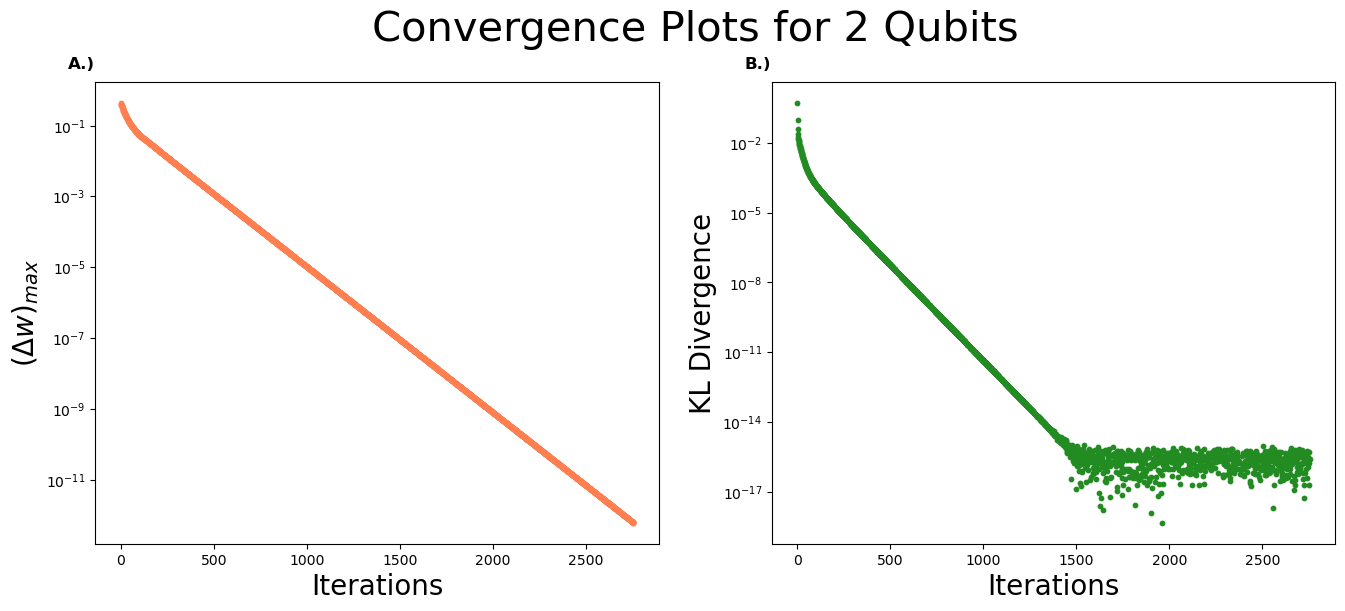

In [12]:
# 2-Qubit system parameters
num_qubits = 2
random_seed = 555

# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to each of the 16 possible interactions
w_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(w_oracle, interaction_matrices)

# learning parameters
learning_rate = 0.6
maxiter = 2**16
tolerance = 1e-14

# set initial weights for QBM
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels)

# train the Quantum Boltzmann Machine to recover the oracle interaction weights
w_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta, w_eta = w_oracle)

# print the recovered interaction weights and the oracle interaction weights for comparison
np.set_printoptions(precision=2, suppress=True)
print("Oracle Weights: \n", w_oracle)
print("QBM Recovered Weights: \n", w_qbm)
print("Error in recovered weights: \n", w_qbm - w_oracle)
print("Summed Error: \n", np.sum(w_qbm - w_oracle))

plot(it, Wdiff, kl, lk, title='Convergence Plots for 2 Qubits', size=10)

- The left graph shows the largest difference between the entries of the oracle weight matrix and the QBM weight matrix vs the amount of iterations (if no oracle weight matrix is provided, it will show the change largest change in w_qbm compared to the previous iteration)  
- The right graph shows the KL divergence vs the amount of iterations  


# Results 3-qubit system

We first check for 2nd order interactions only, and then for a QM hamiltonian with 3rd order interactions.

Oracle Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54 0.04 0.47 0.89 0.48 0.41 0.   0.   0.   0.4  0.   0.   0.
 0.63 0.   0.   0.   0.14 0.17 0.22 0.09 0.05 0.   0.   0.   0.61 0.
 0.   0.   0.64 0.   0.   0.   0.97 0.47 0.41 0.79 0.37 0.   0.   0.
 0.15 0.   0.   0.   0.06 0.   0.   0.  ]
QBM Recovered Weights: 
 [-0.    0.05  0.94  0.69  0.58  0.14  0.95  0.34  0.62  0.45  0.24  0.03
  0.15  0.81  0.65  0.54  0.04  0.47  0.89  0.48  0.41  0.    0.   -0.
  0.4  -0.    0.    0.    0.63 -0.   -0.   -0.    0.14  0.17  0.22  0.09
  0.05 -0.    0.    0.    0.61 -0.    0.    0.    0.64 -0.    0.    0.
  0.97  0.47  0.41  0.79  0.37 -0.    0.    0.    0.15  0.   -0.    0.
  0.06  0.    0.   -0.  ]
Error in recovered weights: 
 [-0.  0. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0.
 -0. -0.  0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0.
  0. -0.  0.  0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0.  0. -0. -0. -0.
  0

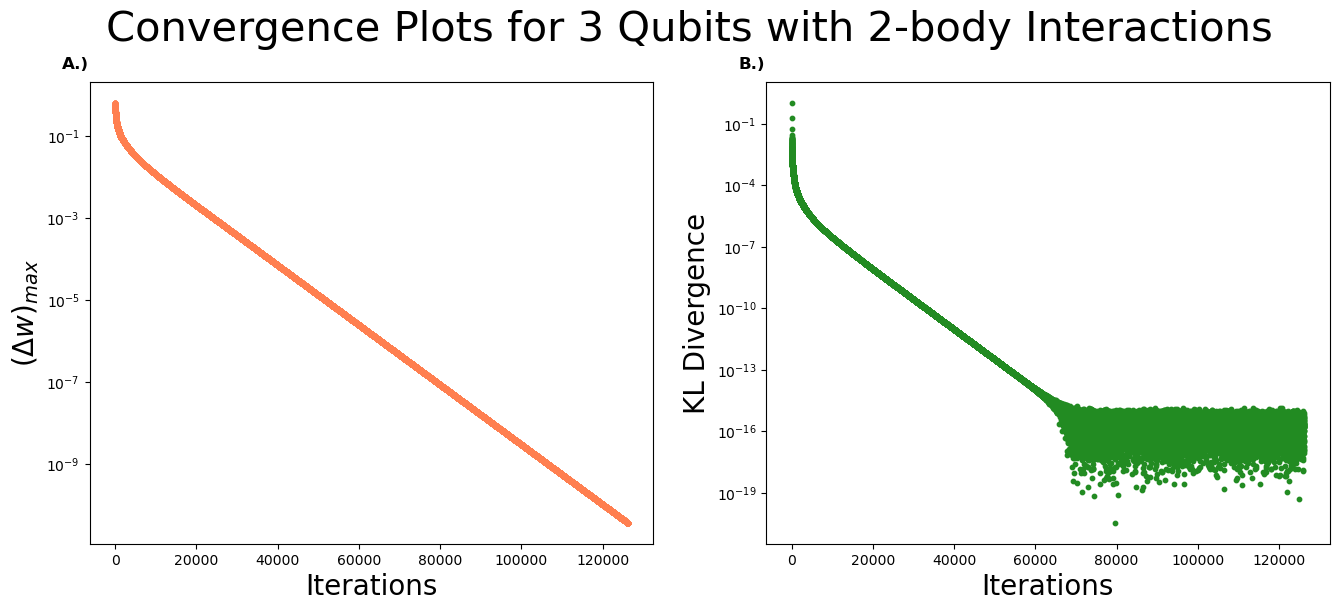

In [13]:
# 3-Qubit system parameters
num_qubits = 3
random_seed = 555

# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to each of the 16 possible interactions
w_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(w_oracle, interaction_matrices)
# learning parameters
learning_rate = 0.6
maxiter = 2**18
tolerance = 1e-14

# set initial weights for QBM
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels)

# train the Quantum Boltzmann Machine to recover the oracle interaction weights
w_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta, w_eta = w_oracle)

# print the recovered interaction weights and the oracle interaction weights for comparison
np.set_printoptions(precision=2, suppress=True)
print("Oracle Weights: \n", w_oracle)
print("QBM Recovered Weights: \n", w_qbm)
print("Error in recovered weights: \n", w_qbm - w_oracle)
print("Summed Error: \n", np.sum(w_qbm - w_oracle))


plot(it, Wdiff, kl, lk, title='Convergence Plots for 3 Qubits with 2-body Interactions', size=10)

Oracle Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54 0.04 0.47 0.89 0.48 0.41 0.62 0.32 0.58 0.4  0.02 0.43 0.41
 0.63 0.5  0.16 0.67 0.14 0.17 0.22 0.09 0.05 0.03 0.44 0.81 0.61 0.66
 0.93 0.49 0.64 0.19 0.25 0.45 0.97 0.47 0.41 0.79 0.37 0.22 0.31 0.29
 0.15 0.74 0.79 0.33 0.06 0.97 0.03 0.79]
QBM Recovered Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54 0.04 0.47 0.89 0.48 0.41 0.62 0.32 0.58 0.4  0.02 0.43 0.41
 0.63 0.5  0.16 0.67 0.14 0.17 0.22 0.09 0.05 0.03 0.44 0.81 0.61 0.66
 0.93 0.49 0.64 0.19 0.25 0.45 0.97 0.47 0.41 0.79 0.37 0.22 0.31 0.29
 0.15 0.74 0.79 0.33 0.06 0.97 0.03 0.79]
Error in recovered weights: 
 [ 0.  0. -0.  0.  0. -0.  0. -0. -0. -0.  0.  0.  0.  0. -0.  0.  0. -0.
 -0. -0. -0. -0.  0. -0. -0. -0.  0.  0.  0. -0. -0.  0.  0.  0. -0. -0.
 -0.  0.  0. -0. -0. -0. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0.  0.  0.
  0. -0. -0. -0. -0.  0. -0. -0.  0. -0.]
Summed Error: 

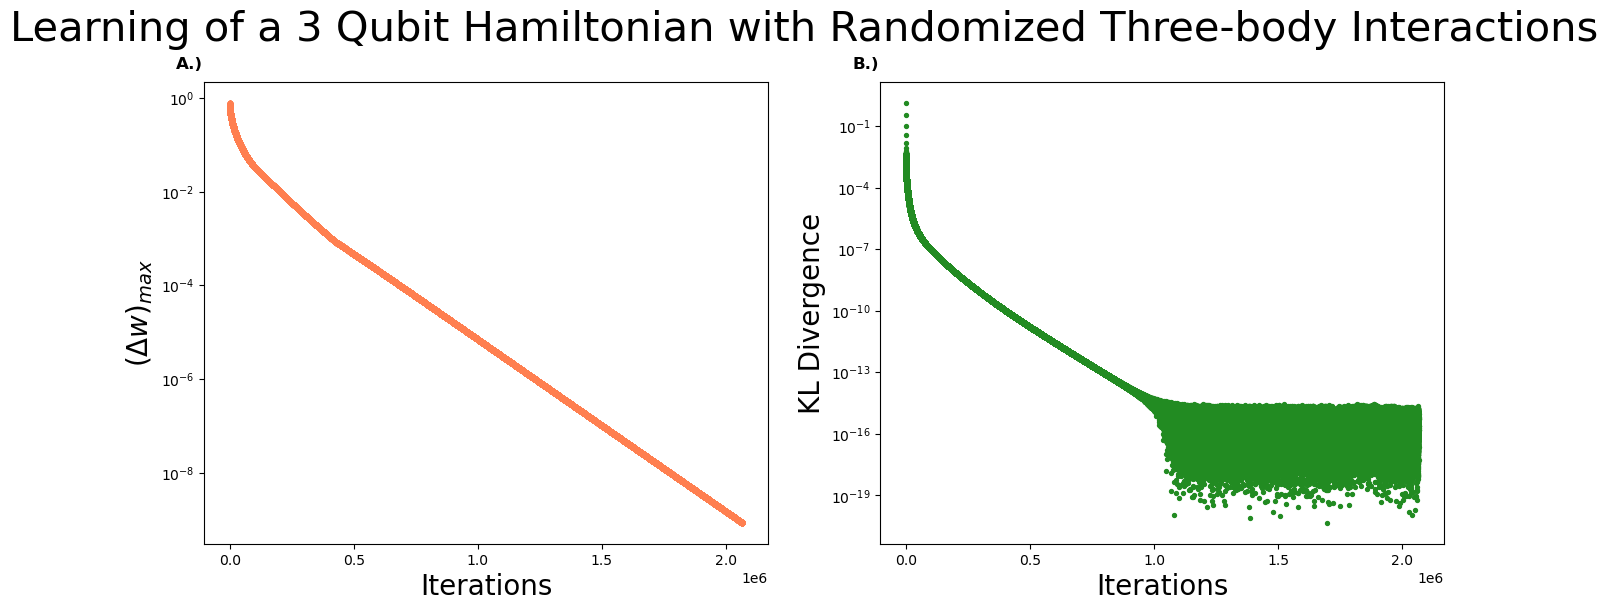

In [14]:
# 3-Qubit system parameters
num_qubits = 3
random_seed = 555

# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to all possible interactions
w_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels, order= 3)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(w_oracle, interaction_matrices)
# learning parameters
learning_rate = 0.7
maxiter = 2**21
tolerance = 1e-14

# set initial weights for QBM
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels, order= 3)

# train the Quantum Boltzmann Machine to recover the oracle interaction weights
w_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta, w_eta = w_oracle)

# print the recovered interaction weights and the oracle interaction weights for comparison
np.set_printoptions(precision=2, suppress=True)
print("Oracle Weights: \n", w_oracle)
print("QBM Recovered Weights: \n", w_qbm)
print("Error in recovered weights: \n", w_qbm - w_oracle)
print("Summed Error: \n", np.sum(w_qbm - w_oracle))


plot(it, Wdiff, kl, lk, title='Learning of a 3 Qubit Hamiltonian with Randomized Three-body Interactions', size=8)

# Results 4-Qubit system

Oracle Weights: 
 [0.   0.05 0.94 0.69 0.58 0.14 0.95 0.34 0.62 0.45 0.24 0.03 0.15 0.81
 0.65 0.54 0.04 0.47 0.89 0.48 0.41 0.   0.   0.   0.4  0.   0.   0.
 0.63 0.   0.   0.   0.14 0.17 0.22 0.09 0.05 0.   0.   0.   0.61 0.
 0.   0.   0.64 0.   0.   0.   0.97 0.47 0.41 0.79 0.37 0.   0.   0.
 0.15 0.   0.   0.   0.06 0.   0.   0.   0.02 0.16 0.15 0.88 0.19 0.
 0.   0.   0.54 0.   0.   0.   0.51 0.   0.   0.   0.73 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.73 0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.81 0.38 0.7  0.24 0.67 0.   0.   0.   0.32 0.   0.   0.
 0.52 0.   0.   0.   0.3  0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.52 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.75 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.47 0.43 0.38 0.51
 0.84 0.   0

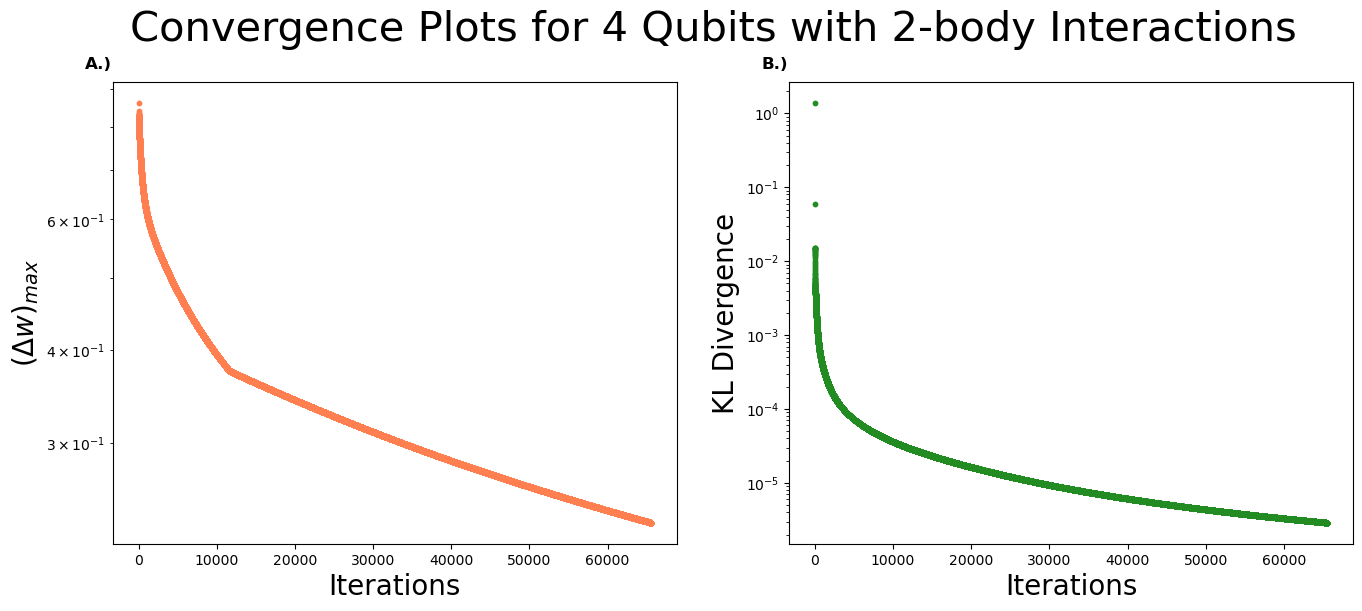

In [16]:
# 4-Qubit system parameters
num_qubits = 4
random_seed = 555

# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to each of the 16 possible interactions
w_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(w_oracle, interaction_matrices)

# learning parameters
learning_rate = 0.73
maxiter = 2**16
tolerance = 1e-14

# set initial weights for QBM
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels)

# train the Quantum Boltzmann Machine to recover the oracle interaction weights
w_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta, w_eta = w_oracle)

# print the recovered interaction weights and the oracle interaction weights for comparison
np.set_printoptions(precision=2, suppress=True)
print("Oracle Weights: \n", w_oracle)
print("QBM Recovered Weights: \n", w_qbm)
print("Error in recovered weights: \n", w_qbm - w_oracle)
print("Summed Error: \n", np.sum(w_qbm - w_oracle))


plot(it, Wdiff, kl, lk, title='Convergence Plots for 4 Qubits with 2-body Interactions', size=10)

Oracle Weights: 
 [0.   0.84 0.68 0.73 0.95 0.01 0.41 0.05 0.1  0.51 0.2  0.74 0.19 0.7
 0.29 0.77 0.01 0.11 0.11 0.25 0.02 0.73 0.34 0.2  0.91 0.98 0.53 0.26
 0.58 0.33 0.89 0.63 0.82 0.55 0.42 0.74 0.37 0.08 0.78 0.22 0.08 0.49
 0.15 0.83 0.19 0.27 0.56 0.9  0.85 0.42 0.39 0.02 0.3  0.35 0.89 0.79
 0.77 0.42 0.78 0.46 0.18 0.88 0.72 0.67 0.26 0.43 0.02 0.23 0.51 0.29
 0.5  0.5  0.1  0.45 0.97 0.74 0.72 0.89 0.96 0.2  0.71 0.16 0.87 0.62
 0.96 0.   0.   0.   0.   0.   0.   0.   0.95 0.   0.   0.   0.7  0.43
 0.17 0.12 0.94 0.   0.   0.   0.75 0.   0.   0.   0.48 0.   0.   0.
 0.3  0.19 0.49 0.04 0.48 0.   0.   0.   0.47 0.   0.   0.   0.66 0.
 0.   0.   0.67 0.39 0.09 0.46 0.64 0.59 0.79 0.8  0.68 0.44 0.26 0.24
 0.84 0.37 0.62 0.47 0.49 0.72 0.65 0.97 0.39 0.   0.   0.   0.03 0.
 0.   0.   0.41 0.   0.   0.   0.9  0.32 0.36 0.71 0.23 0.   0.   0.
 0.94 0.   0.   0.   0.81 0.   0.   0.   0.88 0.83 0.42 0.78 0.49 0.
 0.   0.   0.45 0.   0.   0.   0.51 0.   0.   0.   0.84 0.04 0.08 0.37

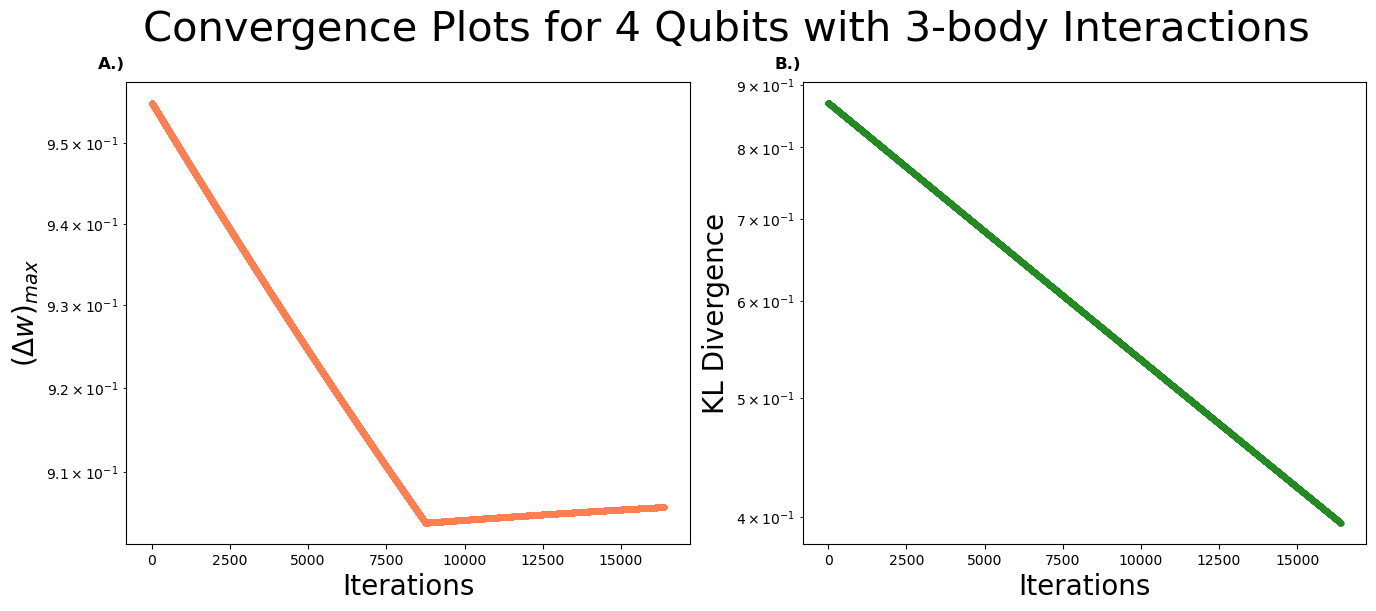

In [18]:
# 4-Qubit system parameters
num_qubits = 4
random_seed = 666

# generate interaction matrices and labels for up to 2-body interactions
interaction_matrices, interaction_labels, interaction_weights = generate_interaction_matrices(num_qubits)

# randomly assign weights to all possible interactions
w_oracle = generate_random_parameter_matrix(random_seed,num_qubits,interaction_labels, order = 3)

# generate the target density matrix using the oracle interaction_weights
eta = rho_model(w_oracle, interaction_matrices)

# learning parameters
learning_rate = 0.00004
maxiter = 2**14
tolerance = 1e-14

# set initial weights for QBM
w_initial= generate_random_parameter_matrix(random_seed + 1, num_qubits, interaction_labels, order = 3)

# train the Quantum Boltzmann Machine to recover the oracle interaction weights
w_qbm, lk, kl, Wdiff, it = quantum_boltzmann_machine(interaction_matrices, learning_rate, maxiter, tolerance, w_initial, eta = eta, w_eta = w_oracle)

# print the recovered interaction weights and the oracle interaction weights for comparison
np.set_printoptions(precision=2, suppress=True)
print("Oracle Weights: \n", w_oracle)
print("QBM Recovered Weights: \n", w_qbm)
print("Error in recovered weights: \n", w_qbm - w_oracle)
print("Summed Error: \n", np.sum(w_qbm - w_oracle))

plot(it, Wdiff, kl, lk, title='Convergence Plots for 4 Qubits with 3-body Interactions', size=10)